In [1]:
import sys
sys.path.append('..')

from spanemo.learner import Trainer, EvaluateOnTest
from spanemo.model import SpanEmo
from spanemo.data_loader import DataClass
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
import json

seed = 12345678

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda:0':
    print("Currently using GPU: {}".format(device))
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print("WARNING: USING CPU")

Currently using GPU: cuda:0


In [12]:
hyperparams = {
    'backbone':'bert-large-uncased',
    'max_length': 128, #maximum context length for the model
    'batch_size': 128,
}

In [15]:
model_path = "models/final_model.pt"
model = SpanEmo(backbone=hyperparams["backbone"])
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()
print()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
def predict(text):
    texts = [text]
    dataset = DataClass(hyperparams, texts, pred_mode=True, label_type="binary")
    data_loader = DataLoader(dataset,
                            batch_size=hyperparams['batch_size'],
                            shuffle=False
                            )
    
    with torch.no_grad():
        current_index = 0
        logits = model.predict(next(iter(data_loader)), device)[2].cpu().numpy()

    return logits

In [20]:
def viz(logits):
    # label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]
    label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]
    probs = 1/(1+np.exp(-logits))[0]

    sorted_pairs = sorted(zip(probs, label_names), reverse=True)
    sorted_labels = [i[1] for i in sorted_pairs]
    sorted_probs = [i[0] for i in sorted_pairs]

    for i in sorted_labels: print(i)
    for i in sorted_probs: print(i)

    ax = sns.barplot(x=sorted_probs, y=sorted_labels)
    ax.bar_label(ax.containers[0], fmt="%.3f")

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


100%|██████████| 1/1 [00:00<00:00, 1650.00it/s]

joy
anticipation
optimism
trust
love
surprise
fear
hopeless
disgust
sadness
anger
0.97963345
0.94327766
0.9327166
0.21743952
0.09118309
0.009716805
0.003274649
0.0021836315
0.0019324392
0.0013189241
0.0008970497


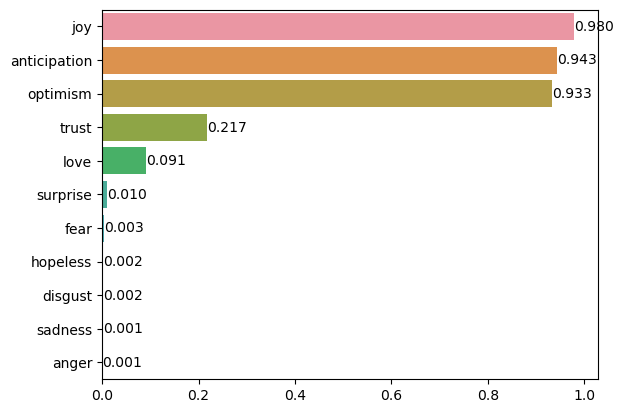

In [22]:
viz(predict("That sounds like a plan! We can start a neighborhood band."))

In [8]:
df = pd.read_csv("data/test.csv")


In [9]:
i = 0

In [10]:
row = df.iloc[i]
print(row["text"])
viz(((row.loc["0":"27"].values.astype(float)-0.5)*100).reshape(1, -1))

i += 1

@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell


KeyError: '27'